# Irony Simulations
## Imports

In [1]:
from typing import Tuple, Optional

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
import torch
import matplotlib
import matplotlib.pyplot as plt

from util import inference_util

from cnn_classifier.emoclass_cnn import *
from util.RAVDESS_dataset_util import *
from util.preprocess_util import *

# Double precision for numerical stability
torch.set_default_dtype(torch.float64)

## Generate Face Expression

In [2]:
emocat.values()

dict_values(['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])

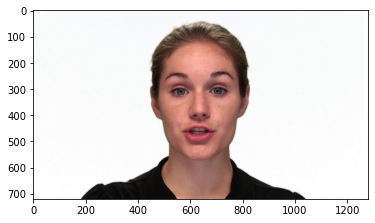

In [3]:
pretrained_model_path = '../trained_models/ravdess_mvae_data_8k_altloss_06.save'
loaded_data = torch.load(pretrained_model_path)
model: torch.nn.Module = build_model(**loaded_data['model_args']).double()
model.load_state_dict(loaded_data['model_params'])
model.eval()

# Select an emotion category
emotion = 2
print(Rd.emocat[emotion])
emotion = torch.tensor([emotion]).to('cuda')

# Generate a face expression
r_image, _, _, _ = model(faces=None, emotions=emotion)
r_image = torch.clamp(r_image, min=0, max=1)
r_image = np.array(r_image.cpu().detach().numpy()[0]).transpose((1, 2, 0))
plt.figure(figsize = (5,5))
plt.imshow(r_image)

## Associate VA from image

In [4]:
# Predict the emotion category associated with the generated face expression
_, r_emotion, _, _ = model(faces=r_image, emotions=None)
pred = torch.argmax(r_emotion.cpu()).item()
print('Prediction: ', Rd.emocat[pred])

ca_loc = torch.tensor(EMOTION_CORE_AFFECT_MAP_LOC[emocat[pred]])
ca_dev = torch.tensor(EMOTION_CORE_AFFECT_MAP_STD_DEV[emocat[pred]])

facevalence_loc_dev = (ca_loc[0], ca_dev[0])
facearousal_loc_dev = (ca_loc[1], ca_dev[1])

valence_dist = dist.Normal(ca_loc[0], ca_dev[0])
arousal_dist = dist.Normal(ca_loc[1], ca_dev[1])

def norm_va(va):
    va = (va - (-1)) / (1 - (-1))
    if va >= 0.99: va = torch.tensor(0.99)
    if va <= 0: va = torch.tensor(0.01)
    return va

face_valence = norm_va(valence_dist.sample())
face_arousal = norm_va(arousal_dist.sample())

print('valence', face_valence, ' arousal', face_arousal)

Prediction:  neutral
valence tensor(0.7427)  arousal tensor(0.4138)


In [5]:
STATES: Tuple[str, ...] = ("terrible", "ok", "amazing")
GOALS: Tuple[str, ...] = ("goal_state", "goal_valence", "goal_arousal")
AROUSAL_VALUES: Tuple[str, str] = ("low", "hi")

## Helper functions

## RSA model priors

In [6]:
STATE_PRIOR = [1, 50, 50]
# Here we introduce the RSA functions - we start with priors
def state_prior() -> str:
    probs: torch.Tensor = torch.FloatTensor(STATE_PRIOR)
    ix: torch.Tensor = pyro.sample("state", dist.Categorical(probs=probs))

    return STATES[ix.item()]

In [7]:
def valence_prior(state: str) -> float:
    # Prior probability of having LOW valence given a particular state
    ps = {"terrible": 0.99, "ok": 0.5, "amazing": 0.01}

    return ps[state]

In [8]:
def arousal_prior(state: str) -> float:
    # Prior probability of having HIGH arousal given a particular state
    ps = {"terrible": 0.9, "ok": 0.1, "amazing": 0.9}

    return ps[state]

In [9]:
def goal_state(goal: str, state, valence, arousal):
    if goal == "goal_state":
        return state
    elif goal == "goal_valence":
        return valence
    elif goal == "goal_arousal":
        return arousal

In [10]:
def goal_prior() -> str:
    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(GOALS)) / len(GOALS)
    goal_index: int = pyro.sample("goal", dist.Categorical(probs=probs)).item()

    return GOALS[goal_index]

In [11]:
def utterance_prior():
    # Utterances and states are equivalent in our case
    utterances = STATES

    # Uniform prior on the goals
    probs: torch.Tensor = torch.ones(len(utterances)) / len(utterances)
    utterance_index: int = pyro.sample("utterance", dist.Categorical(probs=probs)).item()

    return utterances[utterance_index]

## RSA model core functions

In [12]:
# Sampling valence given state and any other sources of valence
def sample_valence(state, high_valence_prob: Optional[float] = None) -> int:
    sampled_valence_prior = valence_prior(state)

    if high_valence_prob is None:
        sample = pyro.sample(
            "valence_prior",
            dist.Bernoulli(probs=sampled_valence_prior)
        ).item()

        # Recall that the probabilities are inverted for valence in the prior
        return -1 if sample == 1 else 1
    else:
        valence_prob_prior = torch.FloatTensor([sampled_valence_prior, 1 - sampled_valence_prior])
        # Invert, again, to get the probability of low valence
        valence_prob_other = 1 - torch.FloatTensor([high_valence_prob, 1 - high_valence_prob])

        # Cue integration between the prior and the rest
        composite_valence_prob = valence_prob_prior * valence_prob_other
        # Normalize
        composite_valence_prob = composite_valence_prob / torch.sum(composite_valence_prob)
        # Select probability of low valence
        valence_prob = composite_valence_prob[0]

        # Sample
        sample = pyro.sample(
            "valence",
            dist.Bernoulli(probs=valence_prob)
        ).item()

        # Recall that the probabilities are inverted for valence in the prior
        return -1 if sample == 1 else 1

In [13]:
# Sampling arousal given state and any other sources of arousal
def sample_arousal(state, high_arousal_prob: Optional[float] = None):
    sampled_arousal_prior = arousal_prior(state)

    if high_arousal_prob is None:
        sample = pyro.sample(
            "arousal_prior",
            dist.Bernoulli(probs=sampled_arousal_prior)
        ).item()

        # Here the probabilities are not inverted
        return AROUSAL_VALUES[int(sample)]
    else:
        arousal_prob_prior = torch.FloatTensor([sampled_arousal_prior, 1 - sampled_arousal_prior])

        # Cue integration between prior and other sources of arousal
        composite_arousal_prob = arousal_prob_prior * high_arousal_prob
        # Normalize
        composite_arousal_prob = composite_arousal_prob / torch.sum(composite_arousal_prob)
        # Choose the probability of HIGH valence
        arousal_prob = composite_arousal_prob[0]

        # Sample
        sample = pyro.sample(
            "arousal",
            dist.Bernoulli(probs=arousal_prob)
        ).item()

        # Here the probabilities are not inverted
        return AROUSAL_VALUES[int(sample)]

In [14]:
# Define RSA meaning function
def literal_interpretation(utterance: str, state: str) -> bool:
    # This is our meaning function
    return utterance == state

In [15]:
# Literal listener
@utils.marginal
def literal_listener(utterance, goal):
    sampled_state = state_prior()

    sampled_valence = sample_valence(sampled_state)
    sampled_arousal = sample_arousal(sampled_state)

    sampled_goal = goal_state(goal, sampled_state, sampled_valence, sampled_arousal)

    log_factor: torch.Tensor = torch.tensor(0.0) if literal_interpretation(utterance, sampled_state) \
        else torch.tensor(-999999.0)
    pyro.factor("literal_meaning", log_factor=log_factor)

    return sampled_goal

In [16]:
# Pragmatic speaker
@utils.marginal
def pragmatic_speaker(state: str, valence: float, arousal: float, goal: str) -> str:
    alpha_scaling_factor: float = 1.0

    sampled_goal: str = goal_state(goal, state, valence, arousal)

    with poutine.scale(scale=torch.tensor(alpha_scaling_factor)):
        sampled_utterance = utterance_prior()
        literal_listener_goal = literal_listener(sampled_utterance, goal)
        pyro.sample("listener", literal_listener_goal, obs=sampled_goal)

    return sampled_utterance

In [17]:
# Pragmatic listener
@utils.marginal
def pragmatic_listener(utterance: str):
    sampled_state = state_prior()
    sampled_valence = sample_valence(
        sampled_state,
        face_valence
    )
    sampled_arousal = sample_arousal(
        sampled_state,
        face_arousal
    )
    sampled_goal = goal_prior()

    speaker_marginal = pragmatic_speaker(sampled_state, sampled_valence, sampled_arousal, sampled_goal)
    pyro.sample("speaker", speaker_marginal, obs=utterance)

    return sampled_state, sampled_valence, sampled_arousal, sampled_goal

## Experiments

In [18]:
PLOT_WIDTH = 15
PLOT_HEIGHT = 8
matplotlib.rcParams['figure.figsize'] = [PLOT_WIDTH, PLOT_HEIGHT]

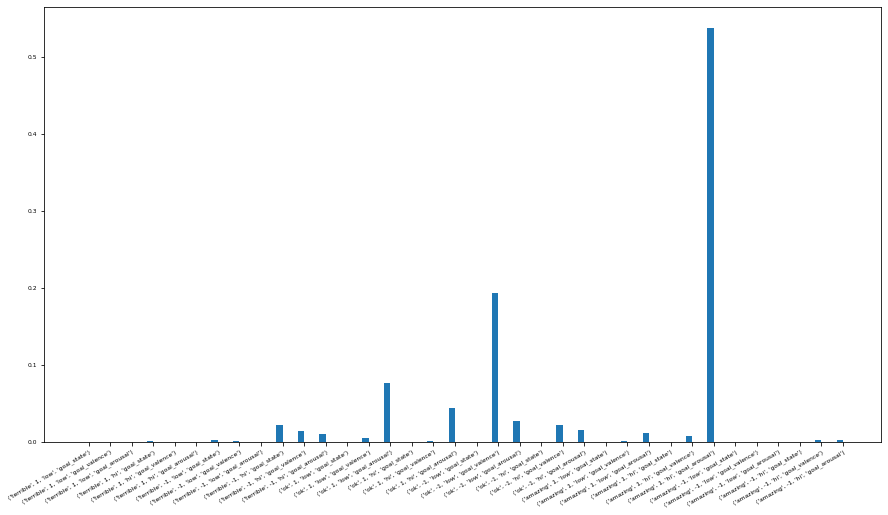

In [19]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_terrible-"+emotion+".pdf")

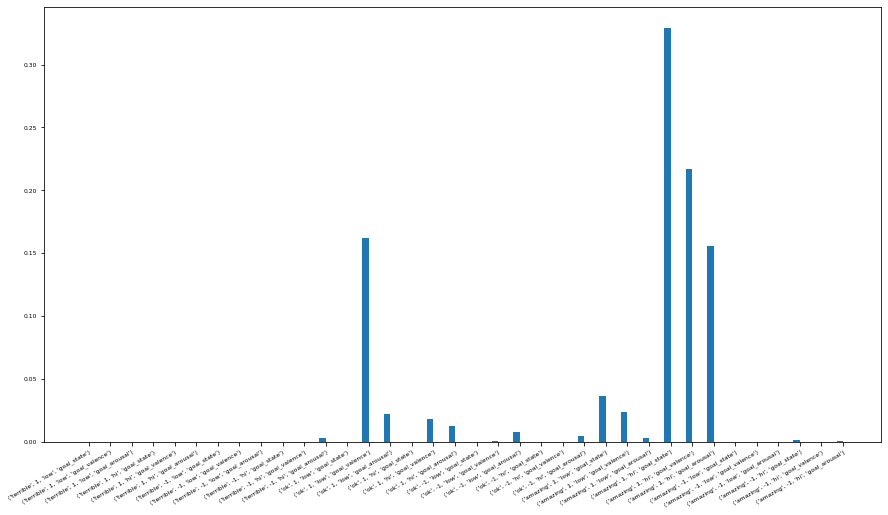

In [20]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_amazing-"+emotion+".pdf")

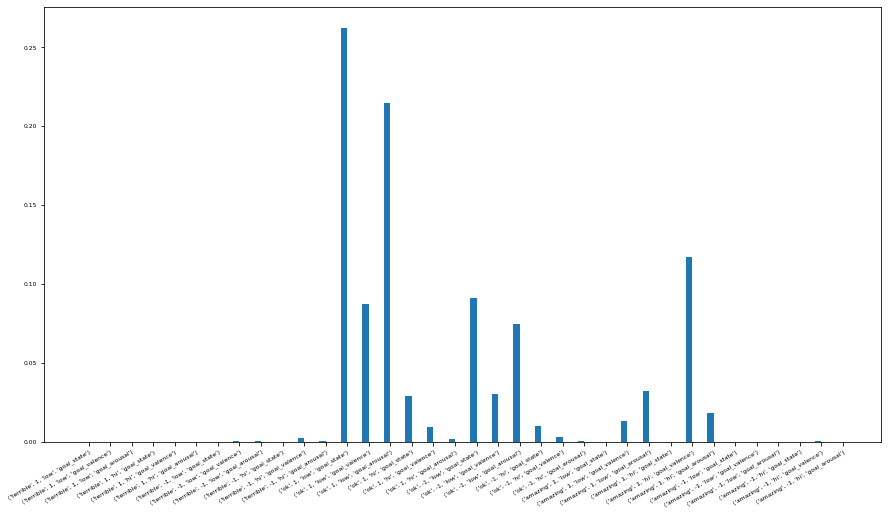

In [21]:
STATE_PRIOR = [1, 50, 50]
rsa_posterior = pragmatic_listener("ok")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_ok-"+emotion+".pdf")

### Altering the state prior

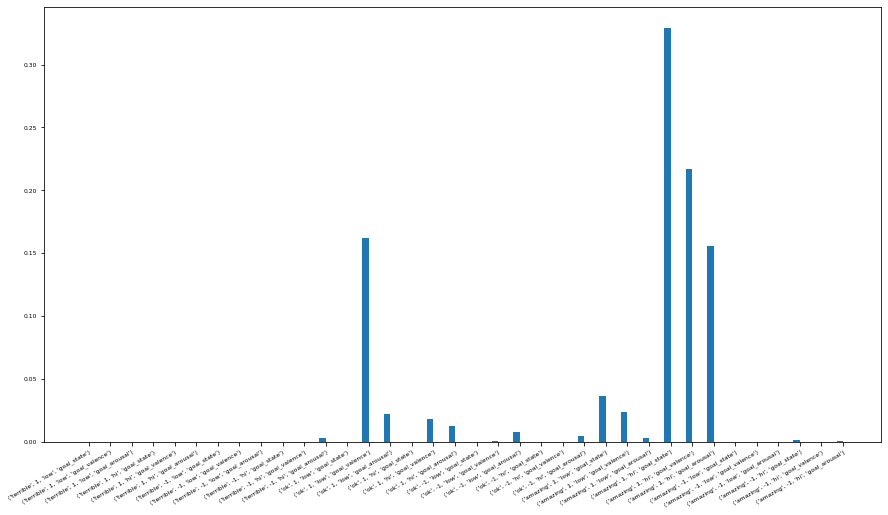

In [22]:
STATE_PRIOR = [1, 50, 1]
rsa_posterior = pragmatic_listener("amazing")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_amazing_alt.pdf")

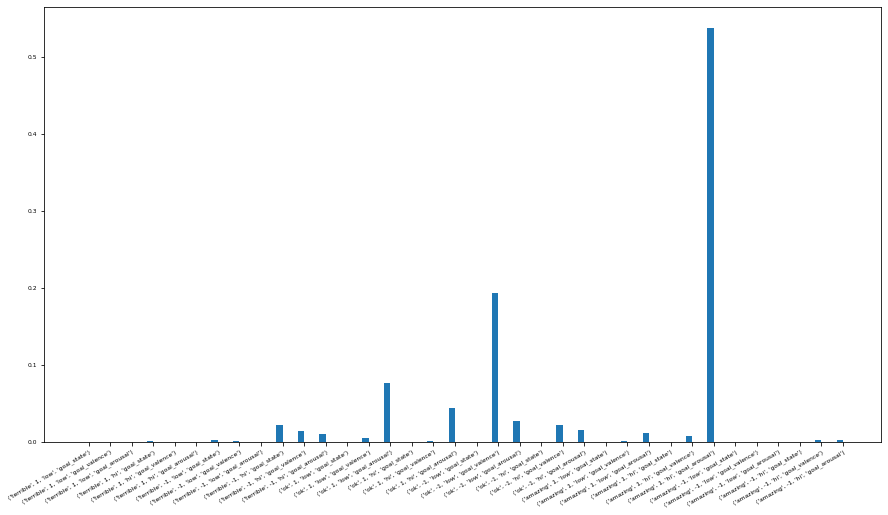

In [23]:
STATE_PRIOR = [100, 1, 1]
rsa_posterior = pragmatic_listener("terrible")
fig = plt.figure()
utils.plot_dist(rsa_posterior)
#fig.savefig("/home/studenti/ballerini/Multimodal_RSA/imgs/irony_orig_terrible_alt.pdf")